In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

In [2]:
preds = pd.read_csv("/glade/work/schreck/repos/evidential/main/results/production/surface_layer/evidential/evaluate/test.csv",
                parse_dates=['Time'])
preds['Date'] = preds['Time'].dt.date.astype("datetime64[ns]")
targets = ['friction_velocity:surface:m_s-1', 'kinematic_sensible_heat_flux:surface:K_m_s-1', 'kinematic_latent_heat_flux:surface:g_kg-1_m_s-1']
for t in targets:
    preds[t + "_abs_error"] = np.abs(preds[t] - preds[t + "_pred"])
    preds[t + "_abs_error_norm"] = (preds[t + "_abs_error"] - preds[t + "_abs_error"].min()) / (preds[t + "_abs_error"].max() - preds[t + "_abs_error"].min())
    preds[t + "_ale_norm"] = (preds[t + "_ale"] - preds[t + "_ale"].min()) / (preds[t + "_ale"].max() - preds[t + "_ale"].min())
    preds[t + "_epi_norm"] = (preds[t + "_epi"] - preds[t + "_epi"].min()) / (preds[t + "_epi"].max() - preds[t + "_epi"].min())

Text(0.5, 0.98, 'Normailized Uncertainties Sorted by Absolute Error (Rolling Mean: n=1000)')

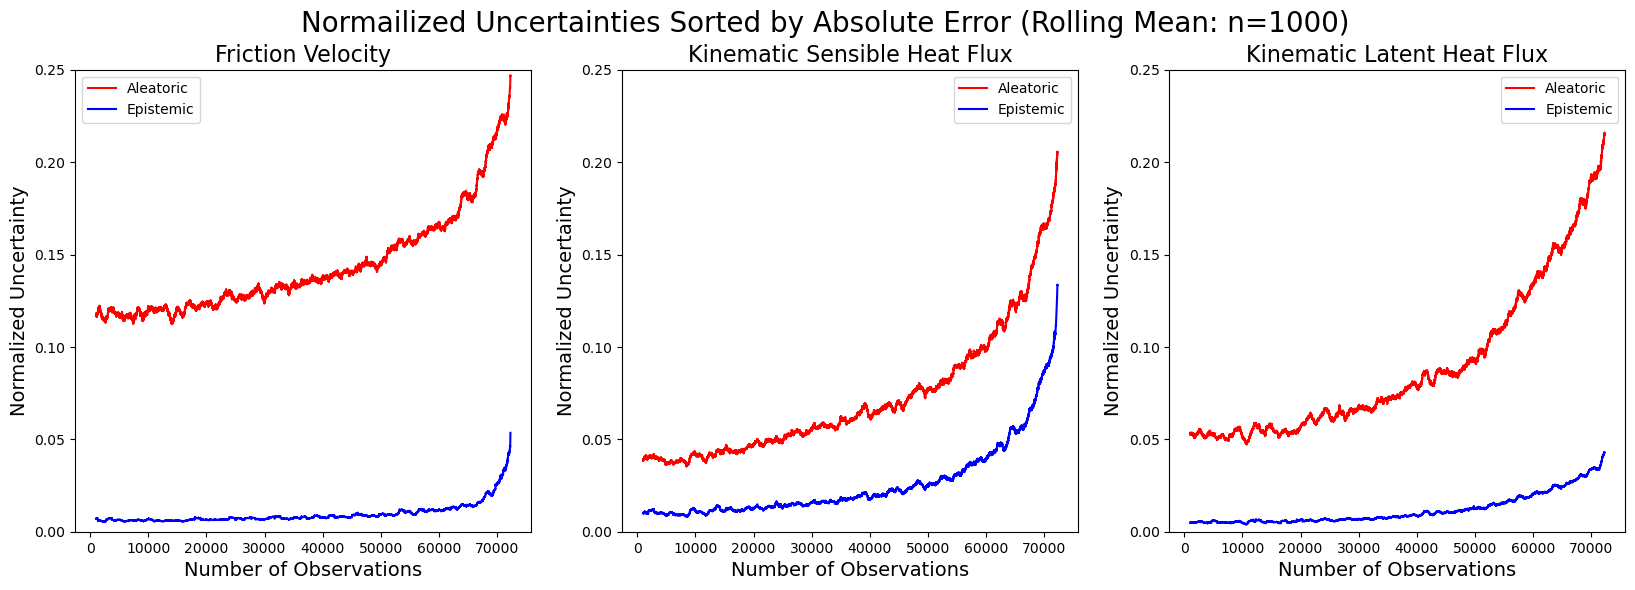

In [13]:
extension = "_epi"
extension_1 = "_ale"

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i in range(3):
    target = targets[i]
    axes[i].plot(preds.sort_values(target + "_abs_error")[target + "_ale_norm"].rolling(1000).mean().values, color='r', label='Aleatoric')
    axes[i].plot(preds.sort_values(target + "_abs_error_norm")[target + "_epi_norm"].rolling(1000).mean().values, color='b', label='Epistemic')
    axes[i].set_ylabel('Normalized Uncertainty', fontsize=14)
    axes[i].set_xlabel('Number of Observations', fontsize=14)
    axes[i].set_title(target.split(":")[0].replace("_", " ").title(), fontsize=16)
    axes[i].set_ylim(0, 0.25)
    axes[i].legend()
plt.suptitle("Normailized Uncertainties Sorted by Absolute Error (Rolling Mean: n=1000)", fontsize=20) 

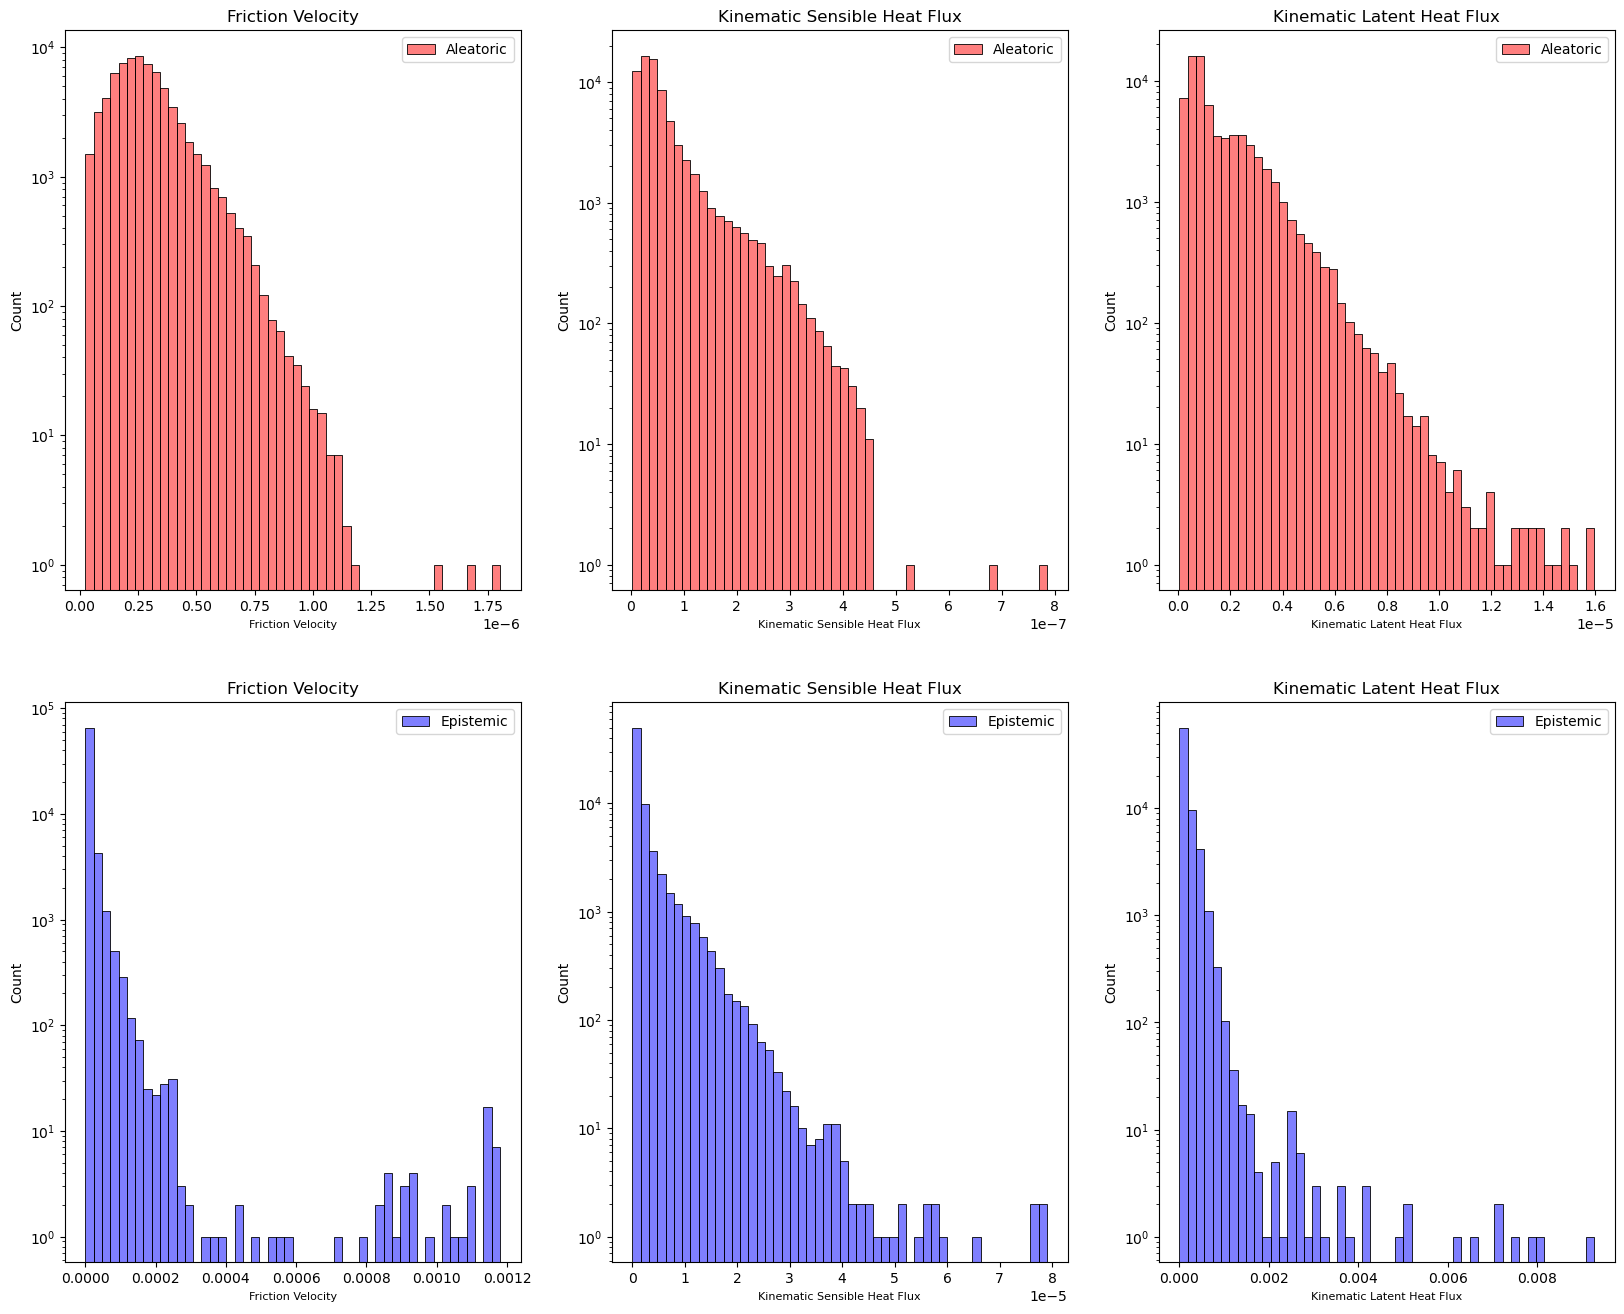

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(20, 16))
for i, ax in enumerate(axes.ravel()):
    if i <= 2:
        target = targets[i]
        sns.histplot(preds[target + '_ale'], bins=50, ax=ax, color='r', label='Aleatoric', alpha=0.5, log=True)
    else:
        target = targets[i - 3]
        sns.histplot(preds[target + '_epi'], bins=50, ax=ax, color='b', label='Epistemic', alpha=0.5, log=True)
    # ax.set_xlim(0, 1e-5)
    title = target.replace('_', " ").split(":")[0].title()
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(title, fontsize=8)
    ax.legend()
# plt.savefig('/glade/scratch/cbecker/SL_uncertainty_hists.png', dpi=300, bbox_inches='tight')

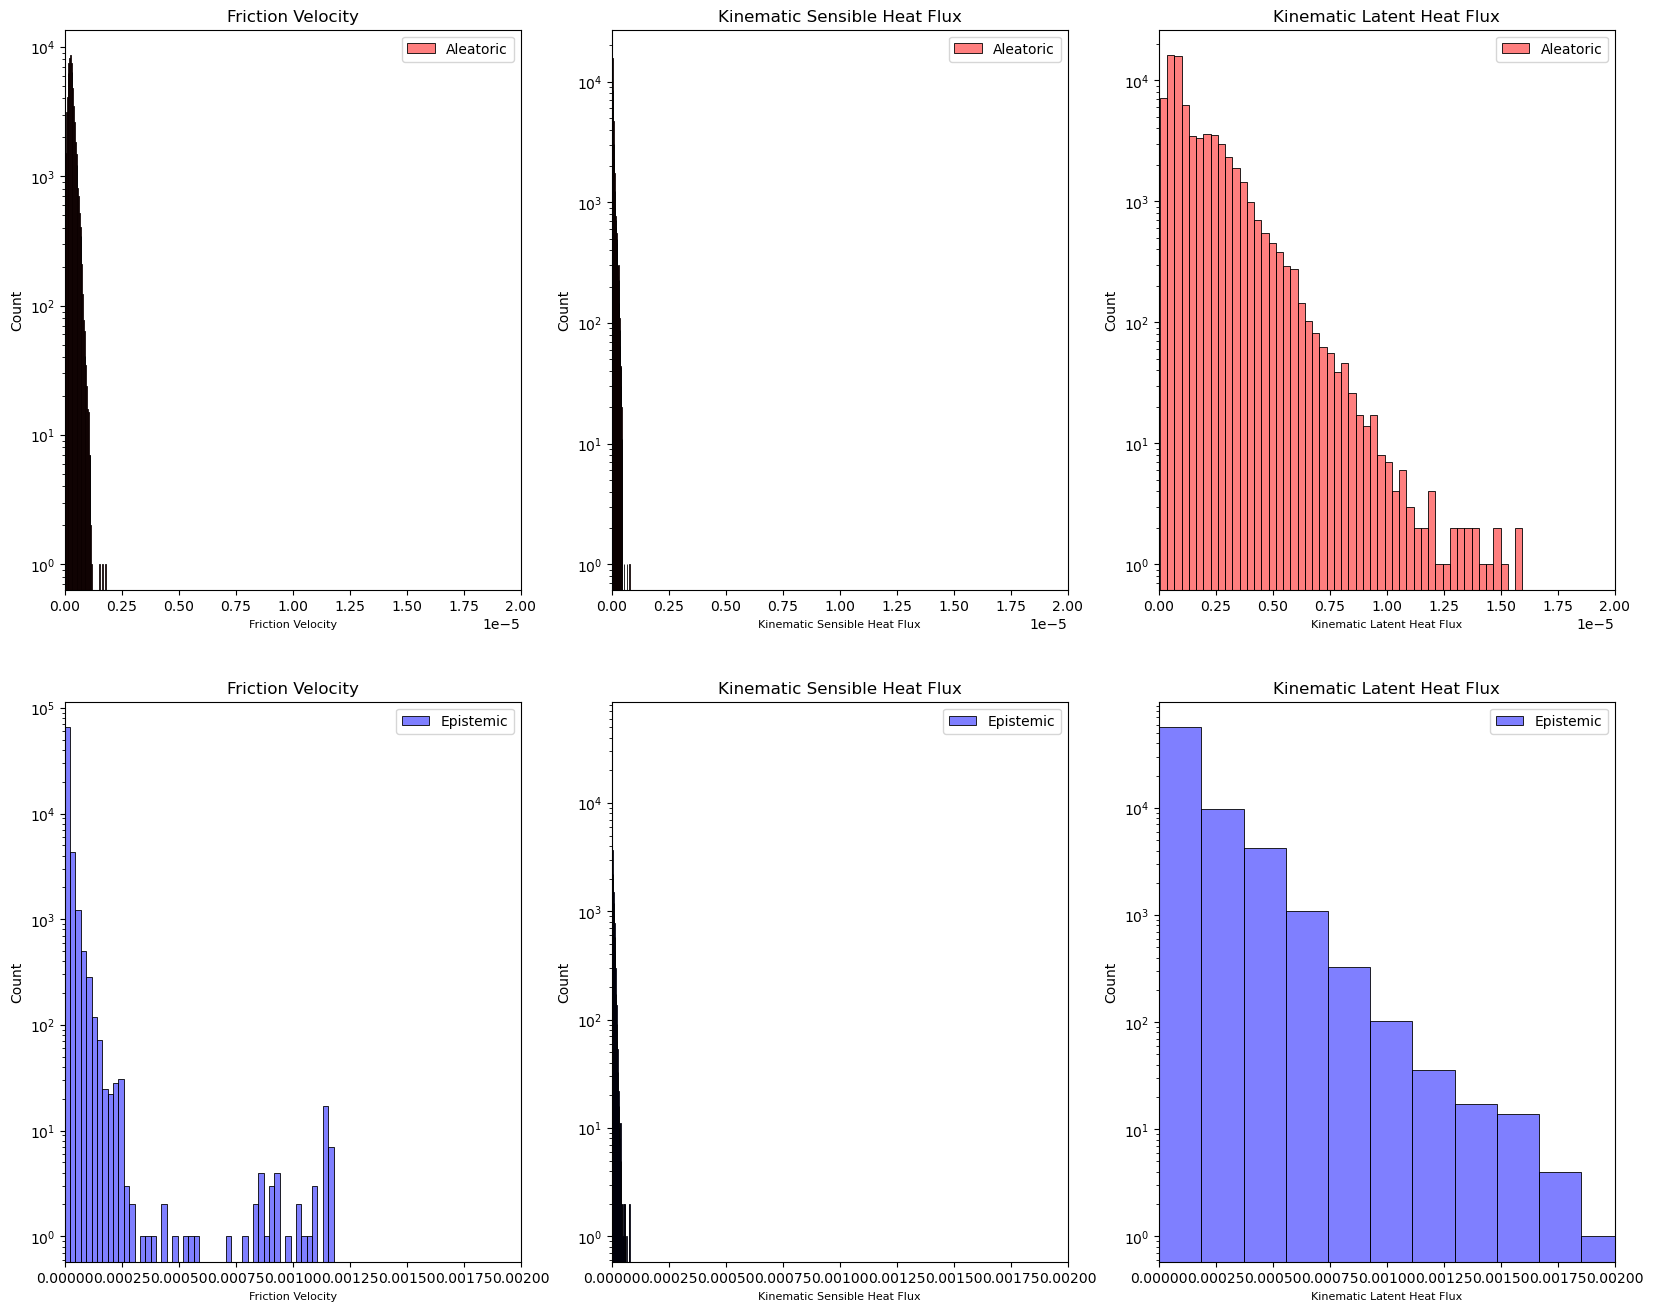

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(20, 16))
for i, ax in enumerate(axes.ravel()):
    if i <= 2:
        target = targets[i]
        sns.histplot(preds[target + '_ale'], bins=50, ax=ax, color='r', label='Aleatoric', alpha=0.5, log=True)
        ax.set_xlim(0, 0.00002)
    else:
        target = targets[i - 3]
        sns.histplot(preds[target + '_epi'], bins=50, ax=ax, color='b', label='Epistemic', alpha=0.5, log=True)
        ax.set_xlim(0, 2e-3)
    title = target.replace('_', " ").split(":")[0].title()
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(title, fontsize=8)
    ax.legend()

In [6]:
dates = []
for t in targets:
    for u in ['_ale', '_epi']:
        index = preds[t + u].idxmax()
        date = preds.iloc[index:index+1]['Time'].dt.strftime('%Y-%m-%d').values[0]
        dates.append(date)
        print(f"Highest {t.split(':')[0] + u} : {date}")

Highest friction_velocity_ale : 2004-06-06
Highest friction_velocity_epi : 2007-01-18
Highest kinematic_sensible_heat_flux_ale : 2004-06-06
Highest kinematic_sensible_heat_flux_epi : 2014-07-27
Highest kinematic_latent_heat_flux_ale : 2007-07-20
Highest kinematic_latent_heat_flux_epi : 2007-01-18


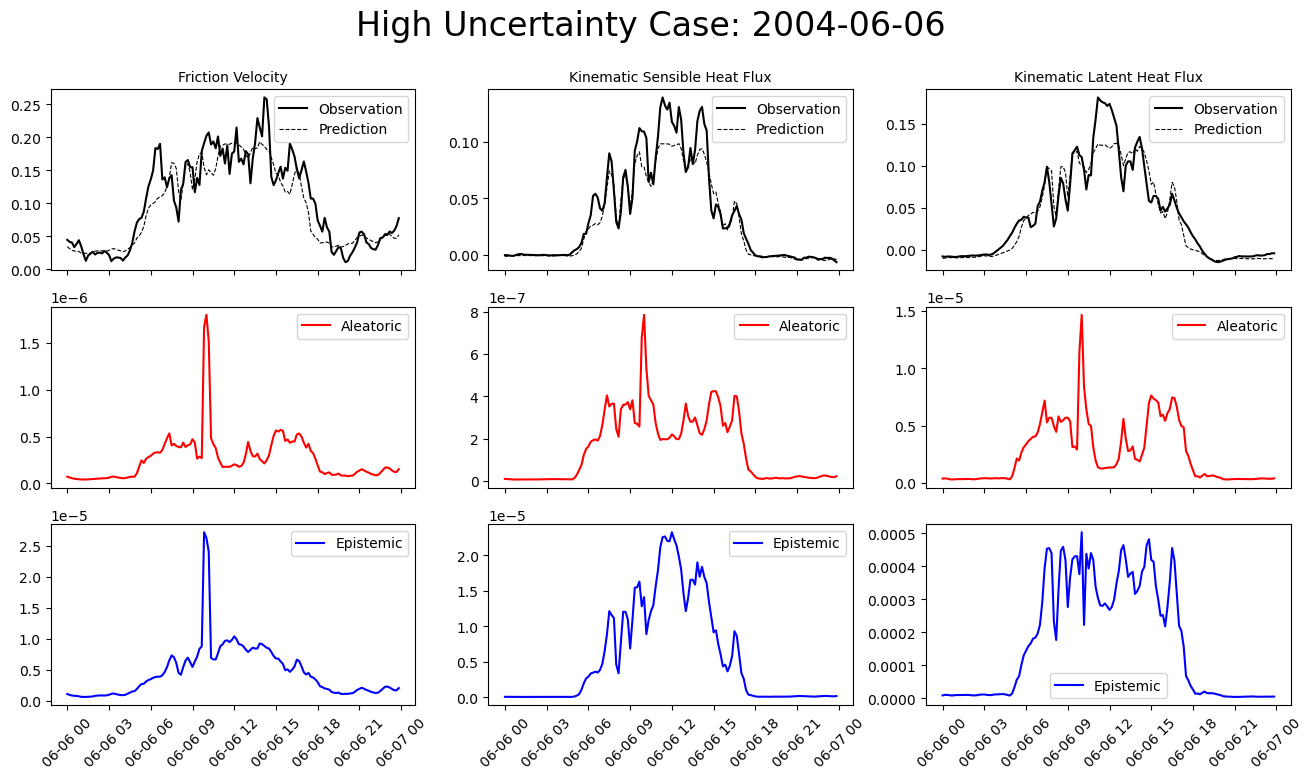

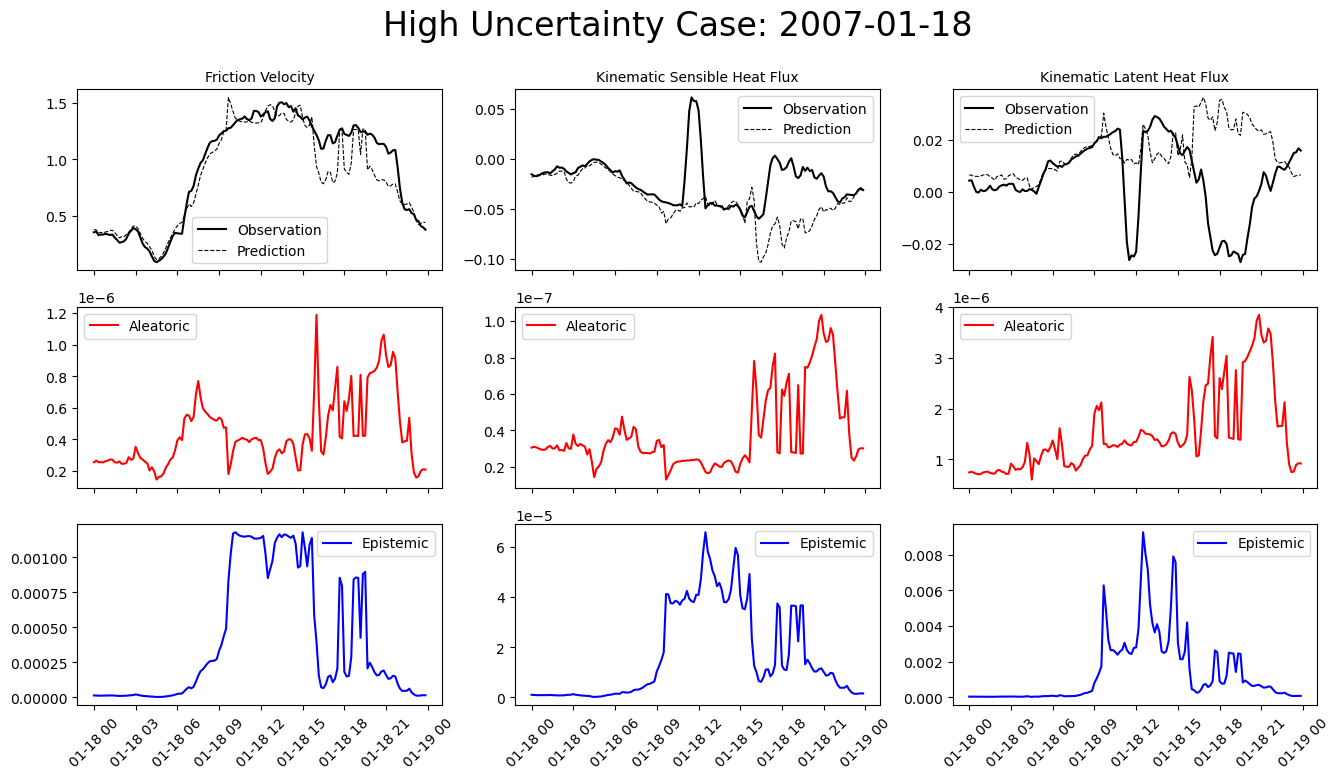

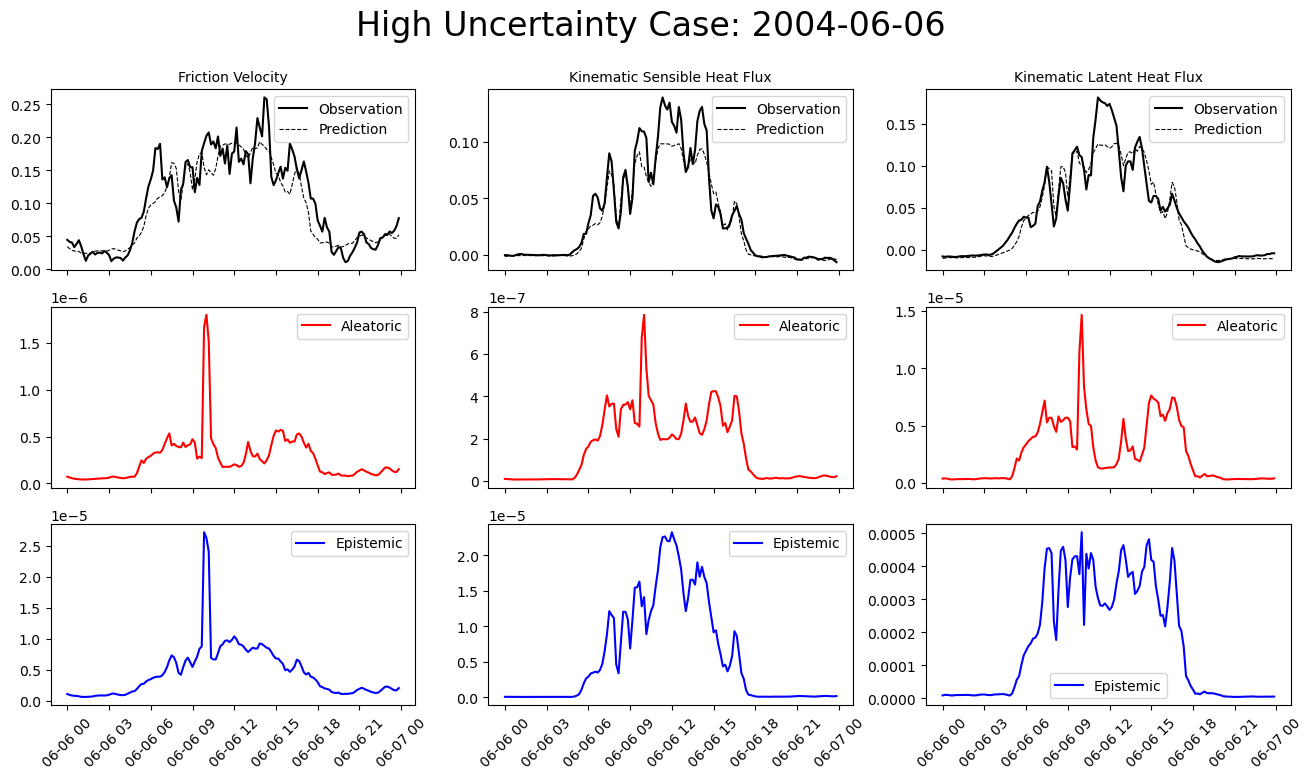

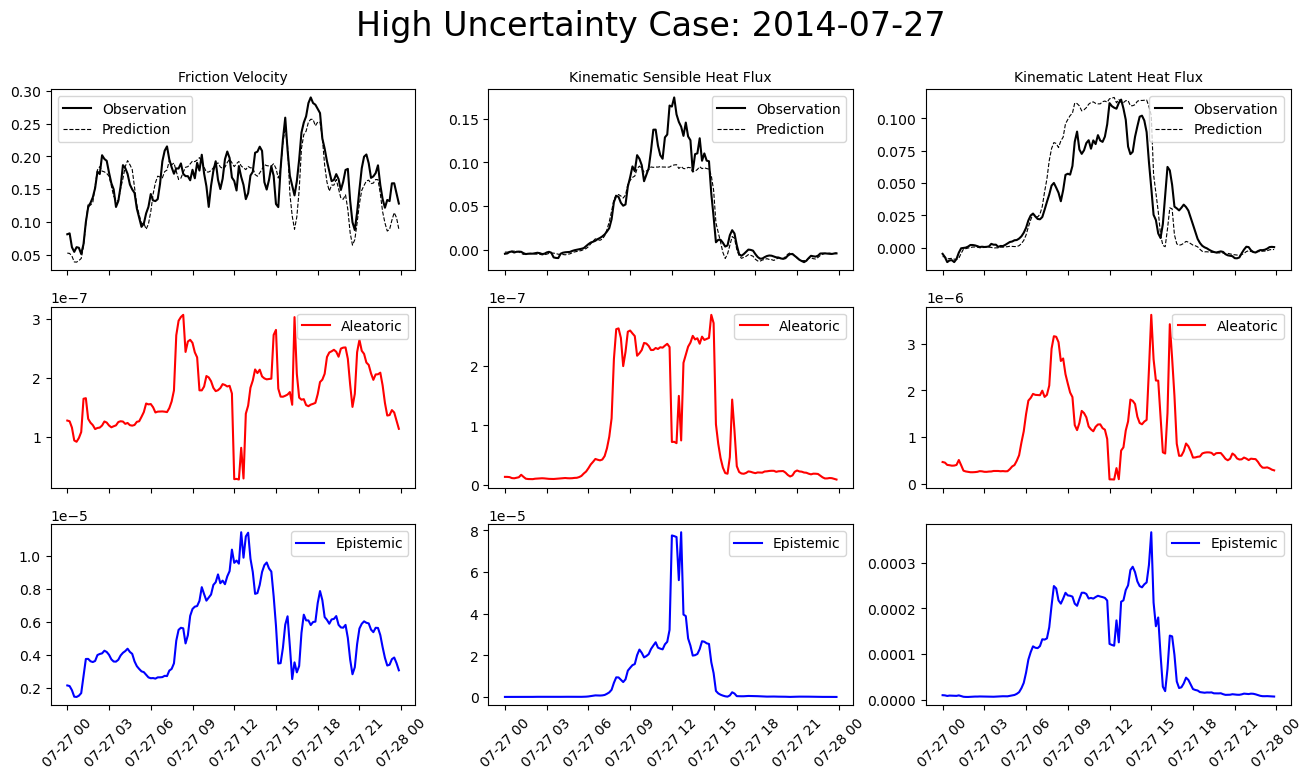

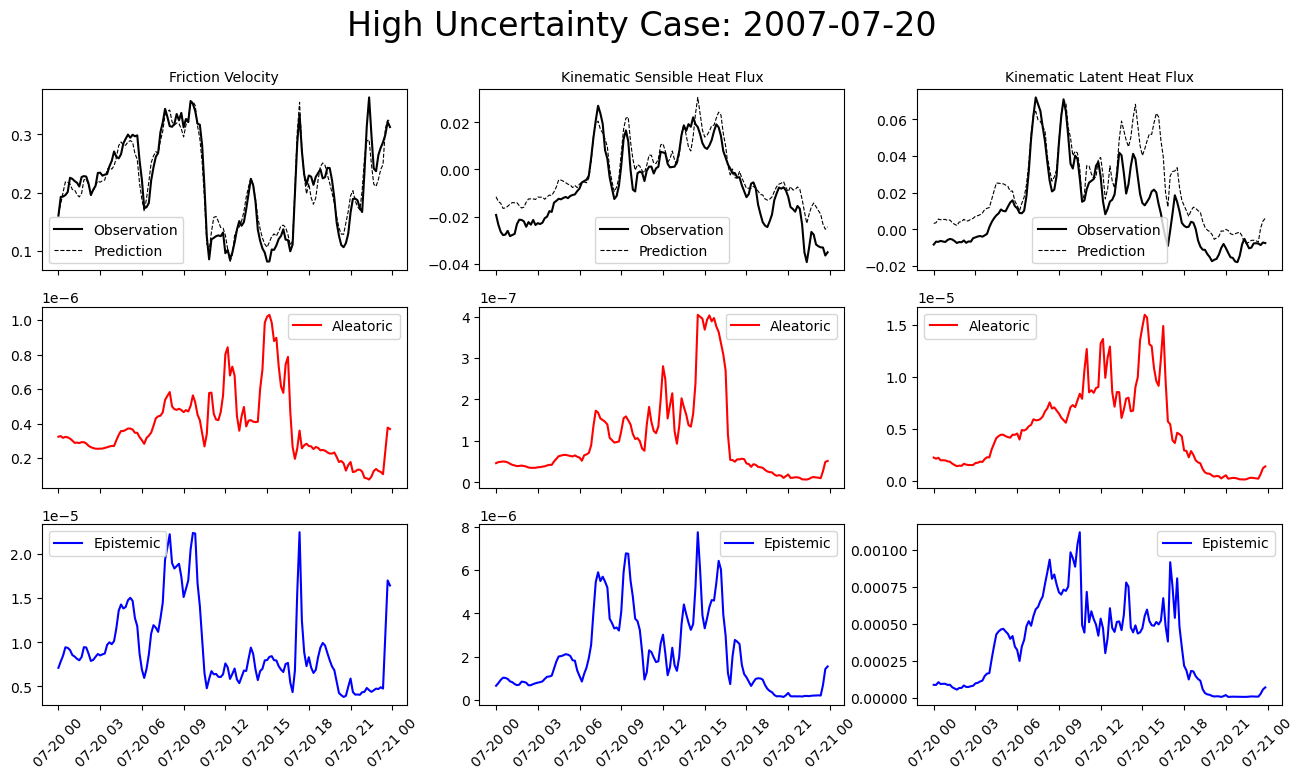

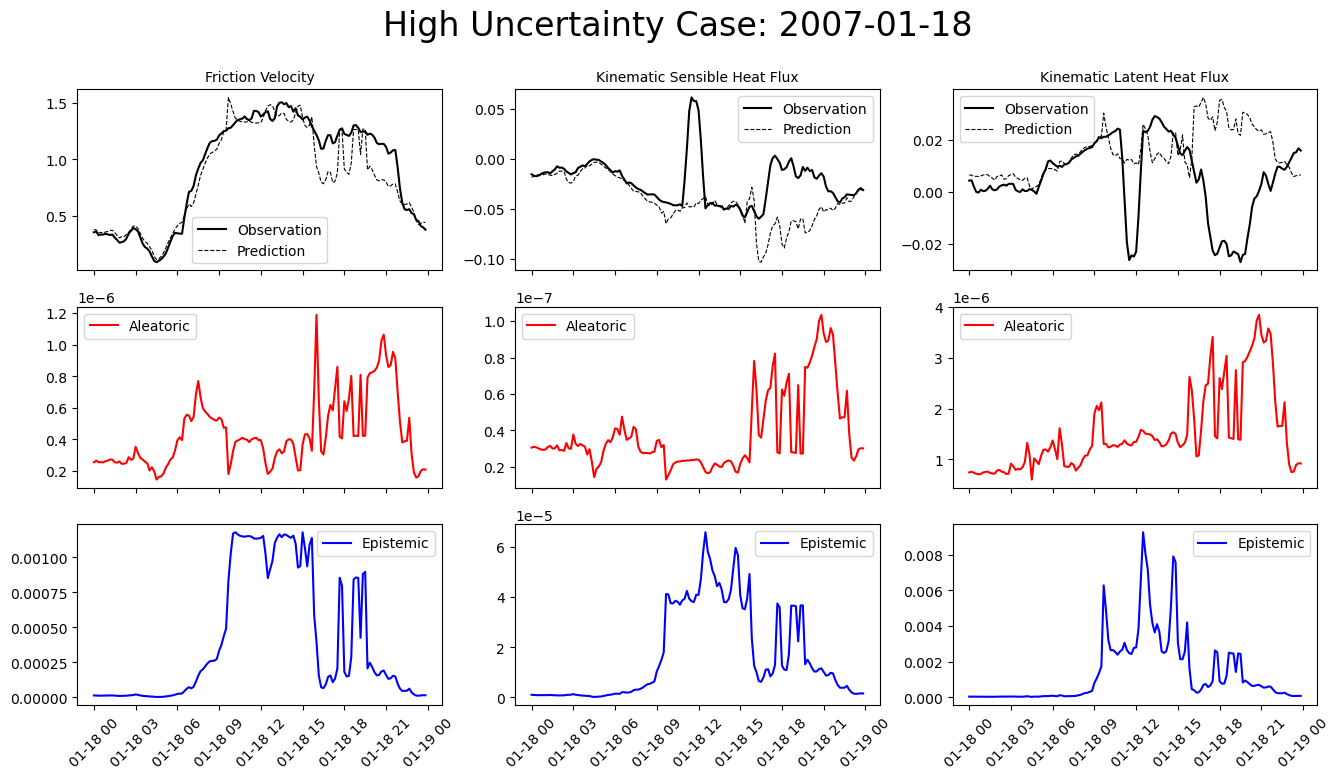

In [7]:
extensions = ["", "_ale", "_epi"]
labels = ["Observation", "Aleatoric", "Epistemic"]
colors = ['k', 'r', 'b']

for date in dates:
    fig, axes = plt.subplots(3, 3, figsize=(16, 8))
    for i in range(3):
        for j in range(3):
            target = targets[j]
            extension = extensions[i]
            subset = preds[preds['Date'] == date]
            axes[i, j].plot(subset['Time'], subset[target + extension], color=colors[i], label=labels[i])
                        
            if i == 2:
                axes[i, j].tick_params(axis='x', labelrotation=45)
            else:
                axes[i, j].set_xticklabels([]) # y-axis
            if i == 0:
                axes[i, j].set_title(target.split(":")[0].replace("_", " ").title(), fontsize=10)
                axes[i, j].plot(subset['Time'], subset[target + "_pred"], color=colors[i], linestyle="--", linewidth=0.8, label="Prediction")
            axes[i, j].legend()
    plt.suptitle(f"High Uncertainty Case: {date}", fontsize=24)

Text(0.5, 0.98, 'Temporal Patterns')

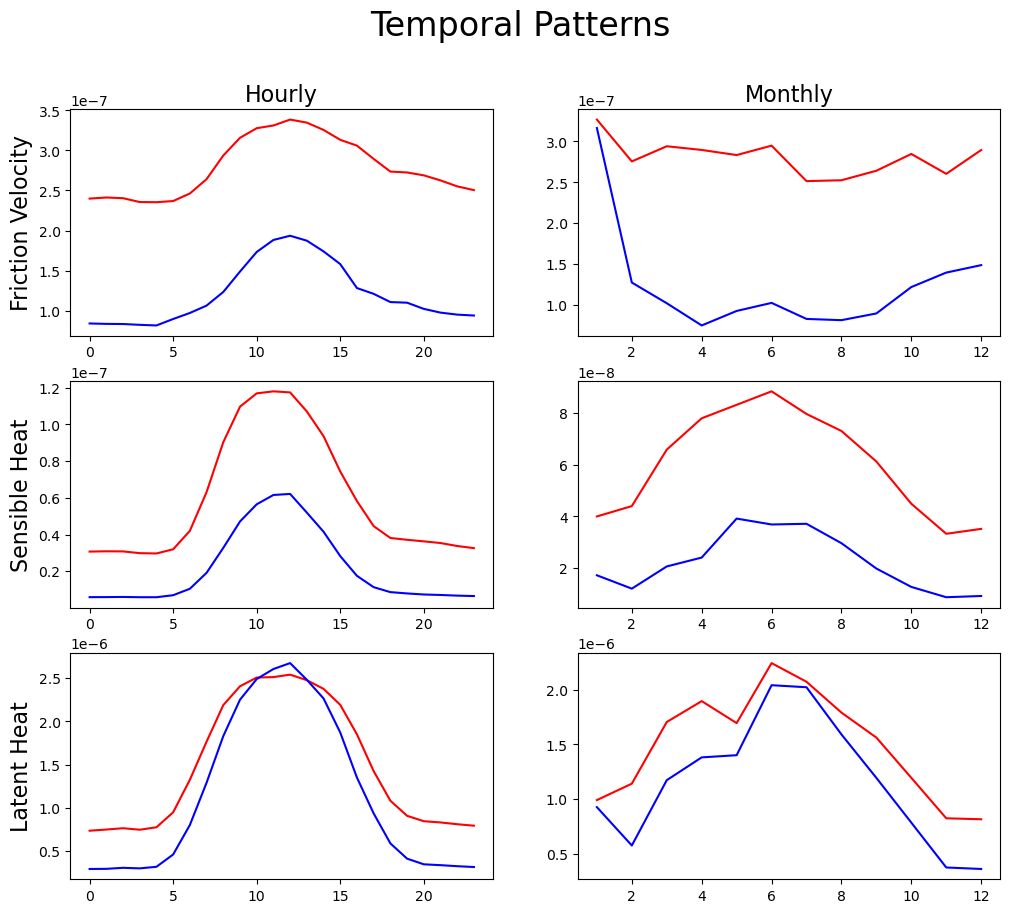

In [8]:
extensions = ["", "_ale", "_epi"]
labels = ["Prediction", "Aleatoric", "Epistemic"]
temporal = ['Hourly', 'Monthly']
labels = ["Friction Velocity", "Sensible Heat", "Latent Heat"]


fig, axes = plt.subplots(3, 2, figsize=(12, 10))
for i in range(3):
    for j in range(2):
        target = targets[i]
        if j == 0:
            a = preds.groupby(preds['Time'].dt.hour)[target + "_ale"].mean()
            e = preds.groupby(preds['Time'].dt.hour)[target + "_epi"].mean()
        elif j == 1:
            a = preds.groupby(preds['Time'].dt.month)[target + "_ale"].mean()
            e = preds.groupby(preds['Time'].dt.month)[target + "_epi"].mean()
            
        axes[i, j].plot(a.index, a, color='r', label='Aleatoric')
        axes[i, j].plot(e.index, e / 100, color='b', label='Epistemic')  # normalization 
        if i == 0:
            axes[i, j].set_title(temporal[j], fontsize=16)
        if j == 0:
            axes[i, j].set_ylabel(labels[i], fontsize=16)
plt.suptitle(f"Temporal Patterns", fontsize=24)

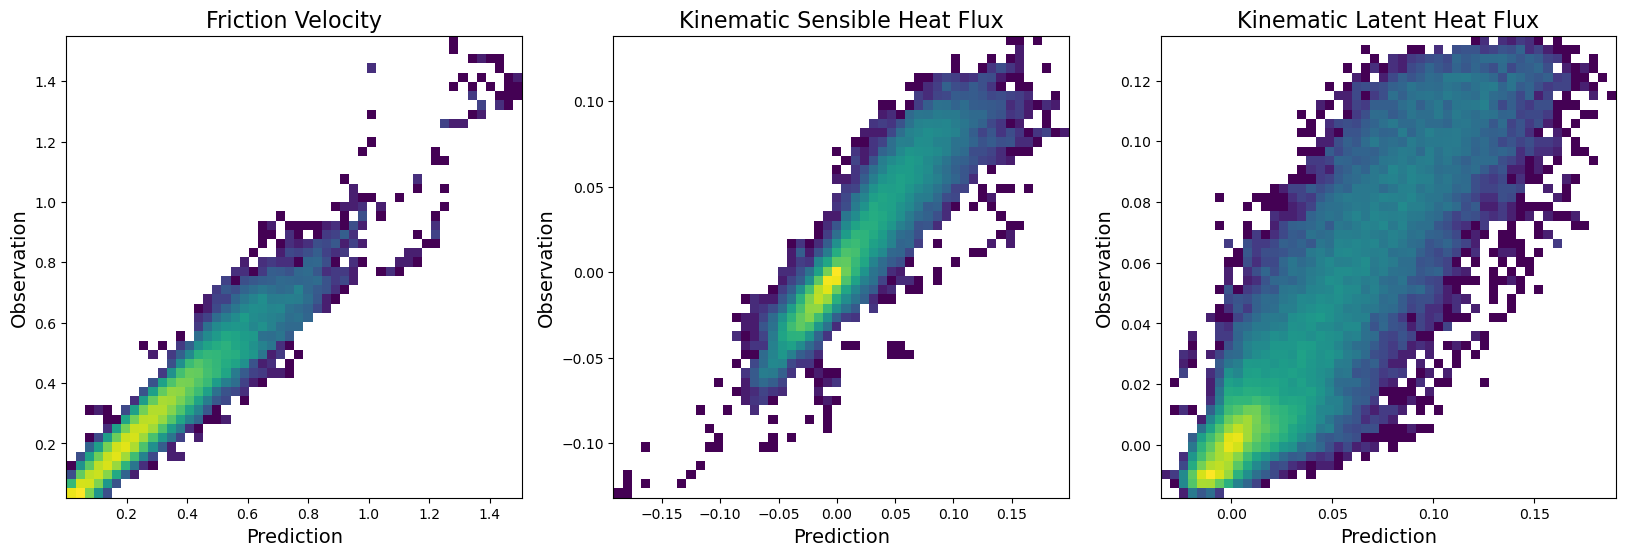

In [9]:
extension = "_pred"

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i in range(3):
    target = targets[i]
    axes[i].hist2d(preds[target], 
                   preds[target + extension],
                   norm=mpl.colors.LogNorm(), bins=50)
    axes[i].set_ylabel('Observation', fontsize=14)
    axes[i].set_xlabel('Prediction', fontsize=14)
    axes[i].set_title(target.split(":")[0].replace("_", " ").title(), fontsize=16)
    

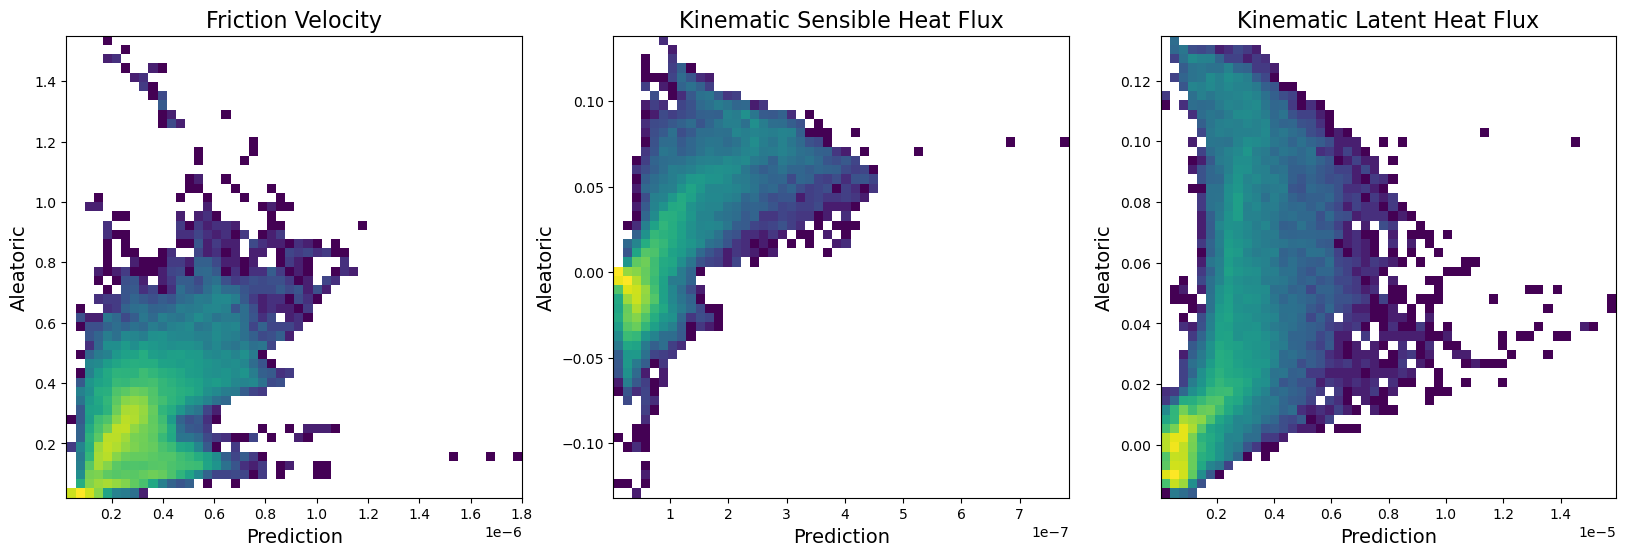

In [10]:
extension = "_ale"

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i in range(3):
    target = targets[i]
    axes[i].hist2d(preds[target + extension], 
                   preds[target + "_pred"],
                   norm=mpl.colors.LogNorm(), bins=50)
    axes[i].set_ylabel('Aleatoric', fontsize=14)
    axes[i].set_xlabel('Prediction', fontsize=14)
    axes[i].set_title(target.split(":")[0].replace("_", " ").title(), fontsize=16)

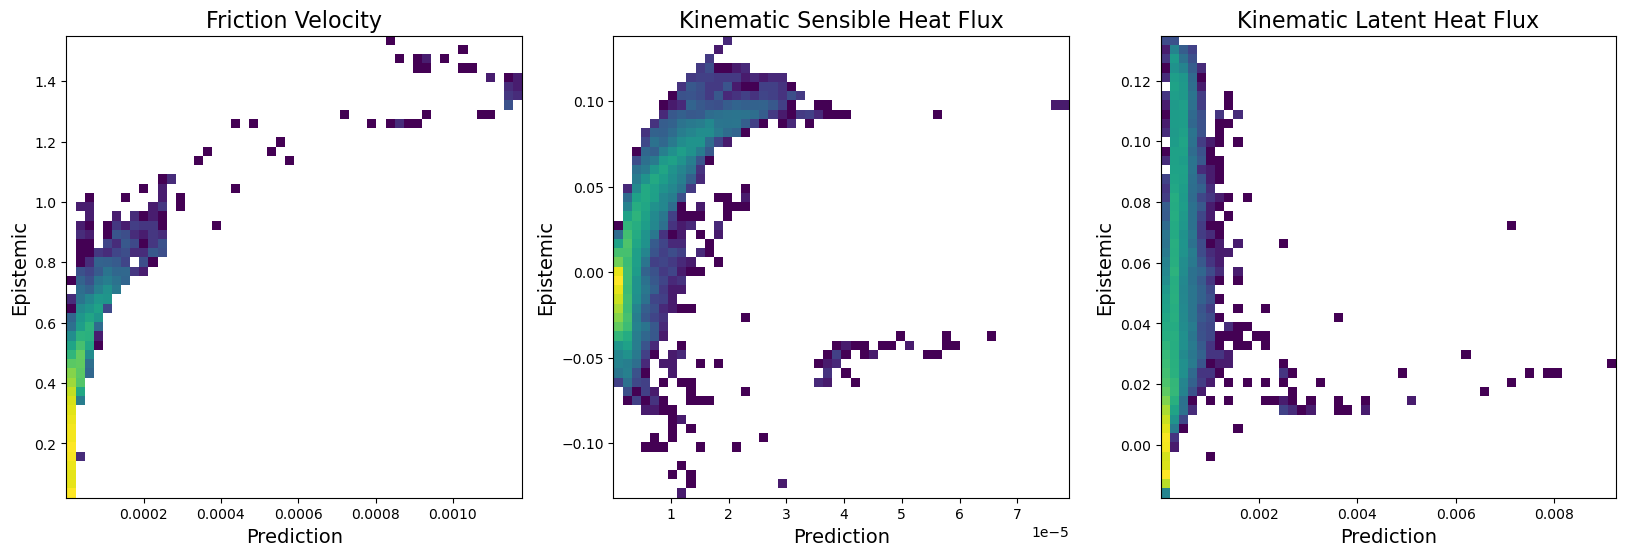

In [11]:
extension = "_epi"

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i in range(3):
    target = targets[i]
    axes[i].hist2d(preds[target + extension], 
                   preds[target + "_pred"],
                   norm=mpl.colors.LogNorm(), bins=50)
    axes[i].set_ylabel('Epistemic', fontsize=14)
    axes[i].set_xlabel('Prediction', fontsize=14)
    axes[i].set_title(target.split(":")[0].replace("_", " ").title(), fontsize=16)

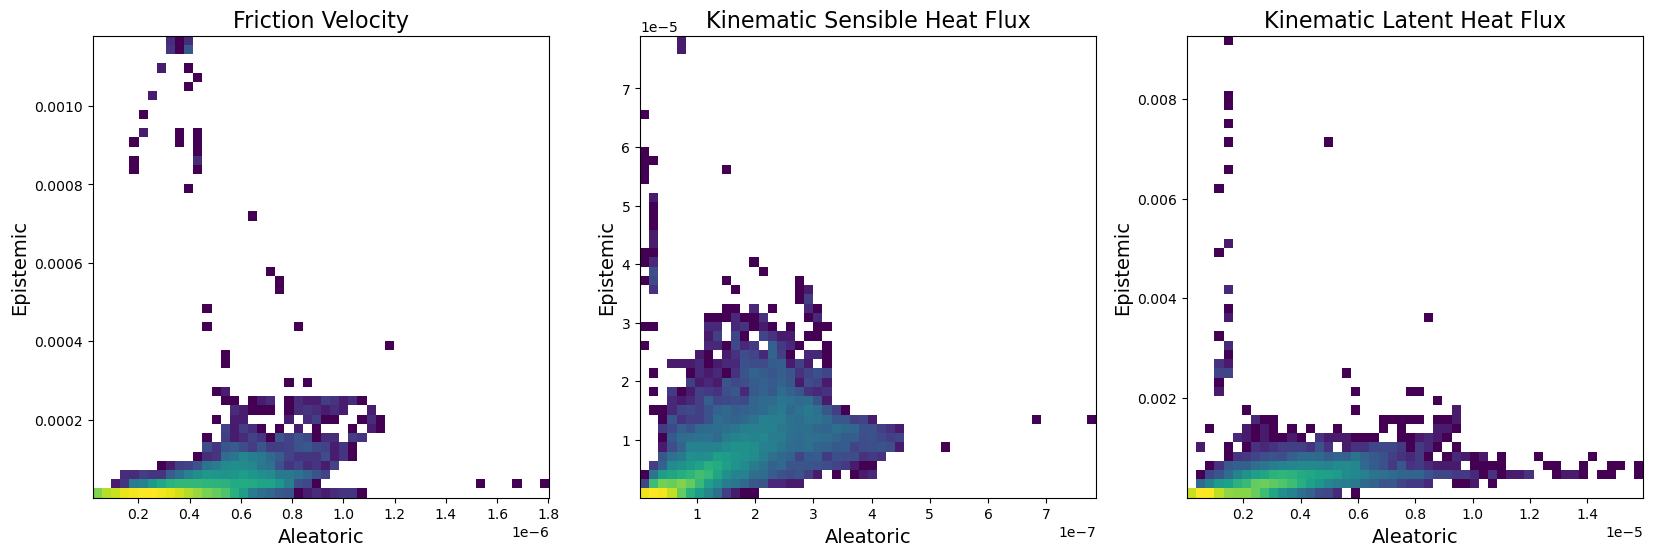

In [12]:
extension = "_epi"
extension_1 = "_ale"


fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i in range(3):
    target = targets[i]
    axes[i].hist2d(preds[target + extension_1], 
                   preds[target + extension],
                   norm=mpl.colors.LogNorm(), bins=50)
    axes[i].set_ylabel('Epistemic', fontsize=14)
    axes[i].set_xlabel('Aleatoric', fontsize=14)
    axes[i].set_title(target.split(":")[0].replace("_", " ").title(), fontsize=16)